## Download and visualize hurricane Maria wind gust speeds

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

import urllib, json, requests

from matplotlib import pyplot as plt 

# For legend
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Load ARA wind speed data downloaded from 
https://disasters.geoplatform.gov/publicdata/NationalDisasters/2017/HurricaneMaria/Data/Wind/ARA/

In [16]:
# Load the ARA wind data csv file
maria_wind_data = pd.read_csv('../data/hurricane/ARA-wind-data/ARA_Hurricane_Maria_Wind_Map_Data_v17.csv')
print('{} wind data records for Hurricane Maria'.format(len(maria_wind_data)))

8128 wind data records for Hurricane Maria


In [17]:
maria_wind_data.describe()

,ID,Lat,LongW,Vg (mph),Vsust (mph),Lon
count,8128.000000,8128.000000,8128.000000,8128.000000,8128.000000,8128.000000
mean,40609.219119,18.216663,66.366362,108.739214,85.656992,-66.366362
std,7303.586683,0.165671,0.610479,18.601086,14.786218,0.610479
min,17089.000000,17.680000,64.279999,53.840000,42.430000,-67.940002
25%,35098.250000,18.090000,66.029999,92.900000,73.000000,-66.830002
50%,41148.500000,18.230000,66.430000,110.350000,86.865000,-66.430000
75%,46454.250000,18.350000,66.830002,124.532500,98.160000,-66.029999
max,64327.000000,18.750000,67.940002,150.430000,124.990000,-64.279999


### Load bounding box for PR, though seems like we may be excluding some counties, not limiting the results for now

In [10]:
# Get the bounding box for Puerto Rico
country = 'Puerto Rico'
r = requests.get(r"http://nominatim.openstreetmap.org/search?q=%s&format=json"%country)
lat_min, lat_max, lon_min, lon_max = json.loads(r.text)[0]["boundingbox"]

In [11]:
lat_min, lat_max, lon_min, lon_max

('17.9268695', '18.5159789', '-67.271492', '-65.5897525')

In [ ]:
# Filter lat/longs that are not within the bounding box
#maria_wind_data = maria_wind_data[(maria_wind_data['Lat'] > float(lat_min)) & (maria_wind_data['Lat'] < float(lat_max))]
#maria_wind_data = maria_wind_data[(maria_wind_data['Lon'] > float(lon_min)) & (maria_wind_data['Lon'] < float(lon_max))]

### Poll Census API server to convert lat/long to counties/blocks

In [7]:
# Lookup the points for lat/long conversion to county names
def get_counties(df):
    df_with_county = df.copy()
    for index, row in df_with_county.iterrows():
        with urllib.request.urlopen('https://geo.fcc.gov/api/census/area?lat=' + str(row['Lat']) + '&lon=' + str(row['Lon']) + '&format=json') as url:
            data = json.loads(url.read().decode())    
            if (len(data['results']) > 0):
                result = data['results'][0]
                df_with_county.loc[index, 'block_fips']  = result['block_fips']
                df_with_county.loc[index, 'county_fips'] = result['county_fips']
                df_with_county.loc[index, 'county_name'] = result['county_name']
                df_with_county.loc[index, 'state_fips']  = result['state_fips']
                df_with_county.loc[index, 'state_code']  = result['state_code']
    return df_with_county

In [8]:
# Poll the Census API server to convert lat/longs to counties/census blocks
# This is an expensive call, read the file below instead.
maria_wind_data_with_county = get_counties(maria_wind_data)

In [113]:
# Let's remove the non-PR states
maria_wind_data_with_county = maria_wind_data_with_county.loc[maria_wind_data_with_county['state_fips'] == '72']

# Save file with mapping
file_name = '../data/hurricane/ARA-wind-data/maria-wind-data-county.csv'
print('Saving {} wind data records with county data for Hurricane Maria at \n {}'.format(len(maria_wind_data_with_county), file_name))
maria_wind_data_with_county.to_csv(file_name, index=True, encoding='utf-8')

Saving 7647 wind data records with county data for Hurricane Maria at 
 ../data/hurricane/ARA-wind-data/maria-wind-data-county.csv


### Visualize the wind gust speed using PR shapefiles

In [21]:
# Helper method to make the legend have custom formatting
def clean_legend(legend):
    for index, label in enumerate(legend.get_texts()):
        if index in (0,1) :
            label_text = label.get_text()
            lower = label_text.split()[1][:-1]
            upper = label_text.split()[2][:-1]    
            new_text = f'{float(lower):,.0f} - {float(upper):,.0f} mph'
            label.set_text(new_text)
        elif index in (2,3):
            label_text = label.get_text()
            lower = label_text.split()[0][1:-1]    
            upper = label_text.split()[1][:-1]    
            new_text = f'{float(lower):,.0f} - {float(upper):,.0f} mph'
            label.set_text(new_text)

In [79]:
def visualize_by_county(wind_data_df):
    # Aggregate by county, use mean reported gust wind speed for the tract
    wind_data_agg_by_county = wind_data_df.groupby(['county_fips']).agg({'Vg (mph)': ['mean']}).reset_index()
    wind_data_agg_by_county.columns = [col_name[0] for col_name in wind_data_agg_by_county.columns.to_flat_index()]
    
    # Load shapefiles for PR
    census_tracts_shp = gpd.read_file('../data/census-tract/shapefiles/cb_2017_72_tract_500k.shp')
    county_shp = census_tracts_shp.dissolve(by=census_tracts_shp.columns[1], aggfunc='first')
    county_shp['COUNTY_FIPS'] = county_shp.apply(lambda row: row.GEOID[0:5], axis=1)
    
    # Merge the dataframes for the county level
    county_shp = county_shp.merge(
        wind_data_agg_by_county.loc[:, ['county_fips', 'Vg (mph)']], 
        left_on='COUNTY_FIPS', right_on='county_fips', how='left')
    
    # Visualize
    fig, ax = plt.subplots(figsize=(15, 10))
    fig_plot = county_shp.plot(column='Vg (mph)', ax=ax, legend=True, cmap='OrRd', scheme='user_defined', 
                                      legend_kwds={'title': 'Saffir-Simpson Hurricane Wind Scale'},
                                      classification_kwds=dict(bins=[96, 111, 130, 157]))
    county_shp.plot(ax=ax, facecolor='none', edgecolor='grey', linewidth=.3)

    # Legend
    legend = fig_plot.get_legend()
    legend._loc = 2
    clean_legend(legend=legend)

    ax.set_title('Hurricane Maria Peak Wind Gust Speed (mph) by County, DataSource: ARA', fontsize=20)
    ax.axis('off')
    plt.tight_layout()

In [77]:
def visualize_by_tract(wind_data_df):
    # Aggregate by county, use mean reported gust wind speed for the county
    wind_data_df['tract_id'] = wind_data_df.apply(lambda row: row.block_fips[0:11], axis=1)
    wind_data_agg_by_tract = wind_data_df.groupby(['tract_id']).agg({'Vg (mph)': ['mean']}).reset_index()
    wind_data_agg_by_tract.columns = [col_name[0] for col_name in wind_data_agg_by_tract.columns.to_flat_index()]

    # Load shapefiles for PR
    census_tracts_shp = gpd.read_file('../data/census-tract/shapefiles/cb_2017_72_tract_500k.shp')
    county_shp = census_tracts_shp.dissolve(by=census_tracts_shp.columns[1], aggfunc='first')
    county_shp['COUNTY_FIPS'] = county_shp.apply(lambda row: row.GEOID[0:5], axis=1)
    
    # Merge the dataframes for the tract level
    census_tracts_shp = census_tracts_shp.merge(
        wind_data_agg_by_tract.loc[:, ['tract_id', 'Vg (mph)']], left_on='GEOID', right_on='tract_id', how='left')
    
    # Visualize
    fig, ax = plt.subplots(figsize=(15, 10))
    fig_plot = census_tracts_shp.plot(column='Vg (mph)', ax=ax, legend=True, cmap='OrRd', scheme='user_defined', 
                                      classification_kwds=dict(bins=[96, 111, 130, 157]), 
                                      legend_kwds={'title': 'Saffir-Simpson Hurricane Wind Scale'},
                                      missing_kwds={'color': 'lightgrey', 'label': 'Missing values'})
    county_shp.plot(ax=ax, facecolor='none', edgecolor='grey', linewidth=.3)

    # Legend
    legend = fig_plot.get_legend()
    legend._loc = 2
    clean_legend(legend=legend)

    ax.set_title('Hurricane Maria Peak Wind Gust Speed (mph) by Census Tract, DataSource: ARA', fontsize=20)
    ax.axis('off')
    plt.tight_layout()

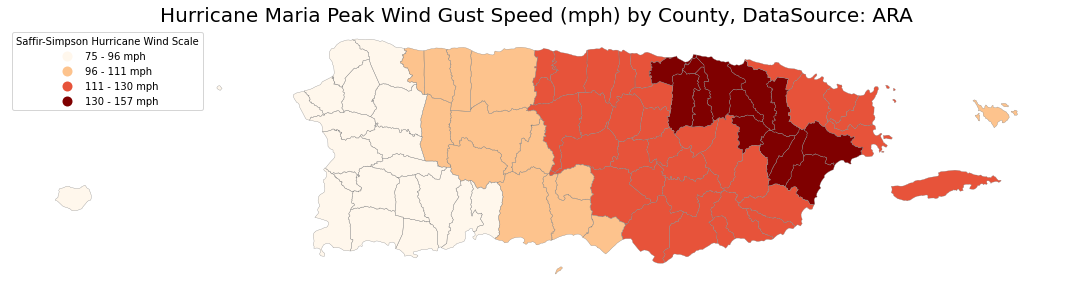

In [80]:
visualize_by_county(maria_wind_data_with_county)

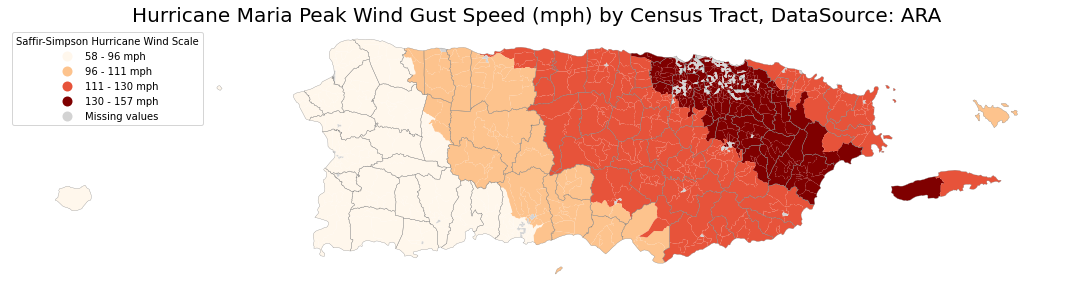

In [78]:
visualize_by_tract(maria_wind_data_with_county)

### Missing Tract wind-data

In [112]:
wind_data_tracts = maria_wind_data_with_county['tract_id'].unique()
census_tracts_shp = gpd.read_file('../data/census-tract/shapefiles/cb_2017_72_tract_500k.shp')
census_tracts = census_tracts_shp['GEOID'].unique()
missing_tracts = [x for x in census_tracts if x not in wind_data_tracts]
print('Number of missing tracts from wind-data: {}'.format(len(missing_tracts)))
print('Missing tracts grouped by county,\n', census_tracts_shp[census_tracts_shp['GEOID'].isin(missing_tracts)]['COUNTYFP'].value_counts())

Number of missing tracts from wind-data: 157
Missing tracts grouped by county,
 127    58
021    18
031    11
113     9
033     9
025     7
137     7
061     7
097     5
139     4
013     2
005     2
043     2
087     2
145     1
057     1
035     1
153     1
151     1
027     1
089     1
067     1
053     1
049     1
063     1
111     1
055     1
011     1
Name: COUNTYFP, dtype: int64
